# Caso Práctico Final: Predicción de Fraude

El conjunto de datos para este caso práctico trata sobre fraude de cuentas bancarias (BAF) y se publicó en NeurIPS 2022. Comprende un total de 6 conjuntos de datos tabulares sintéticos diferentes sobre fraude de cuentas bancarias. 

El enlace a la publicación puedes encontrarlo aquí:
[Enlace publicación](https://arxiv.org/pdf/2211.13358.pdf)

Para este caso práctico trabajaremos con el dataset preprocesado en el caso final de la asignatura Data Science: Análisis Exploratorio de Datos. Siempre es necesario preprocesar los datos para adaptarlos para que funcionen como entrada de un modelo de Machine Learning, de modo que aprovecharemos esta parte del trabajo ya hecha.


In [2]:
import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score,ConfusionMatrixDisplay,classification_report, RocCurveDisplay, PrecisionRecallDisplay

from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import GridSearchCV


from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler,LabelEncoder
# Esconder advertencia 
import warnings

pd.set_option('display.max_columns', None)

In [2]:
warnings.filterwarnings(action='ignore')

# Lectura de datos

Utiliza los datos que preocesaste en el caso final de la asignatura de Análisis Exploratorio de Datos, ya que en dicho caso práctico los datos obtenidos serían los necesarios para introducir a un modelo de machine learning.

In [3]:
#Lectura de datos
df = pd.read_csv('base_depurado.csv', sep = ',').sample(frac=.1)

### Análisis de la variable objetivo

Plotea un diagrama de barras de la variable objetivo y obten el porcentaje de ceros y unos ¿Qué observas?

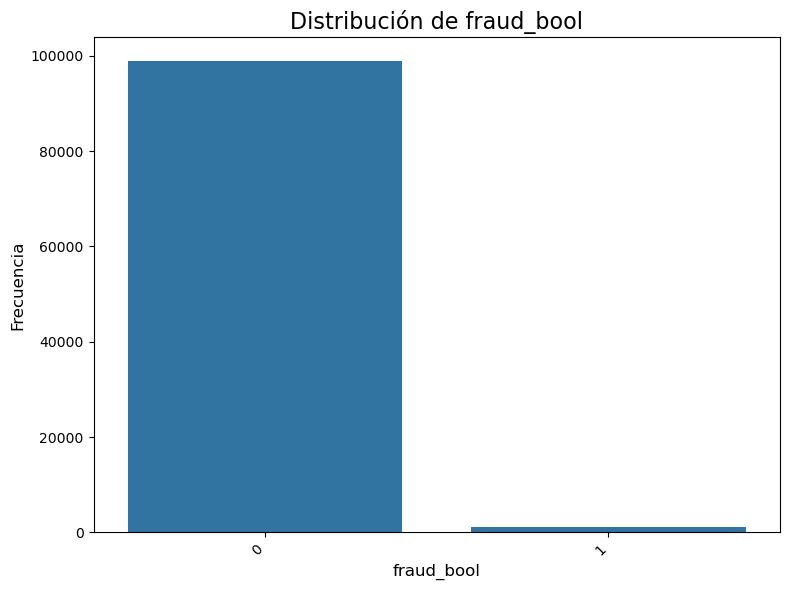

In [4]:
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='fraud_bool')
plt.title(f'Distribución de fraud_bool', fontsize=16)
plt.xlabel('fraud_bool', fontsize=12)
plt.ylabel('Frecuencia', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [5]:
df['fraud_bool'].value_counts(normalize = True)

fraud_bool
0    0.98924
1    0.01076
Name: proportion, dtype: float64

# Clasificación

## Técnicas de balanceo

Hay diferentes técnicas que nos permiten lidiar con el desbalanceo de la variable objetivo. Aquí se describen algunas de ellas:

1. Remuestreo de datos:
    * Sobremuestreo (Oversampling): Aumenta el número de instancias de la clase minoritaria.
    * Submuestreo (Undersampling): Reduce el número de instancias de la clase mayoritaria.
    * Remuestreo combinado: Combina técnicas de sobremuestreo y submuestreo para equilibrar las clases.
2. Generación de muestras sintéticas:
    * SMOTE (Synthetic Minority Over-sampling Technique): Genera nuevas instancias sintéticas de la clase minoritaria mediante interpolación entre instancias similares.
3. Ponderación de clases:
    * Ajusta los pesos de las clases durante el entrenamiento para dar más importancia a la clase minoritaria.

A continuación genera diferentes datasets aplicando las diferentes técnicas e implementa un modelo de clasificación con cada uno de ellos y analiza las diferencias.


In [6]:
# Revisando los tipos de variables
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, 507534 to 838481
Data columns (total 25 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   fraud_bool                        100000 non-null  int64  
 1   income                            100000 non-null  float64
 2   name_email_similarity             100000 non-null  float64
 3   current_address_months_count      100000 non-null  float64
 4   customer_age                      100000 non-null  int64  
 5   payment_type                      100000 non-null  object 
 6   zip_count_4w                      100000 non-null  int64  
 7   date_of_birth_distinct_emails_4w  100000 non-null  int64  
 8   employment_status                 100000 non-null  object 
 9   credit_risk_score                 100000 non-null  float64
 10  email_is_free                     100000 non-null  float64
 11  housing_status                    100000 non-null  o

### Transformando variables object o catogoricas en numericas para trabajor con los modelos

In [7]:
# Seleccionando las variables categoricas del conjunto de datos.
columnas_object = list(df.select_dtypes(include='object').columns)

In [8]:
# Creando una instancia del metodo para la transformacion de las varibles
le = LabelEncoder()

In [9]:
# Creando un for para la automatizar el proceso de la tranformar las variables.
for col in df[columnas_object].columns:
    df[col] = le.fit_transform(df[col])
    print(df[col].value_counts())    

payment_type
1    37238
0    25725
2    25215
3    11787
4       35
Name: count, dtype: int64
employment_status
0    73016
1    13762
5     4502
2     3806
3     2634
4     2238
6       42
Name: count, dtype: int64
housing_status
2    37212
1    26127
0    17057
4    16834
3     2586
5      150
6       34
Name: count, dtype: int64
source
0    99291
1      709
Name: count, dtype: int64
device_os
2    34341
0    33049
3    26486
1     5397
4      727
Name: count, dtype: int64


In [10]:
# Dividiendo la variable objetivos y las variables predicotras
X = df.drop('fraud_bool', axis = 1)
Y = df['fraud_bool']

In [11]:
# Estandarizando los datos
scaler = StandardScaler()
X_C = scaler.fit_transform(X)

In [12]:
#En primer lugar divide los datos en conjunto de entrenamiento y train.
# Division datos de prueba y entrenamiento
X_train, X_test, Y_train, Y_test = train_test_split(X_C, Y, test_size=0.3, random_state=42)

Las técnicas de balanceo se aplicarán sobre los conjuntos de entrenamiento. El conjunto de test debe de ser el inicial, que sea un conjunto que el modelo no haya visto ni haya sido modificado.

### Oversampling: 
Implica duplicar instancias aleatorias de la clase minoritaria hasta que se equilibre con la clase mayoritaria.
El código para realizar esta ténica se proporciona.

In [13]:
oversample = RandomOverSampler(sampling_strategy='minority')
X_over, Y_over = oversample.fit_resample(X_train, Y_train)

### Undersampling: 
Implica eliminar instancias aleatorias de la clase mayoriataria hasta que se equilibre con la clase mayoritaria.
El código para realizar esta ténica se proporciona.

In [14]:
undersample = RandomUnderSampler(sampling_strategy='majority')
X_under, Y_under = undersample.fit_resample(X_train, Y_train)

### SMOTE: 
SMOTE genera instancias sintéticas de la clase minoritaria basándose en los datos existentes, lo que reduce el riesgo de sobreajuste.
El código para realizar esta ténica se proporciona.

In [15]:
smote = SMOTE(random_state=42)
X_resampled, Y_resampled = smote.fit_resample(X_train, Y_train)

## Modelado

Para este caso práctico aplicara el algoritmo Random Forest para calcular las predicciones. Aplica este modelo utilizando cada uno de los conjuntos de datos generados anteriormente y obtén las métricas para evaluar el rendimienot del modelo. ¿Qué técnica ha funcionado mejor? 
¿Por qué?

Si no recuerdas como realizar un modelo de clasificación y su evaluación, puedes repasar lo visto en el caso práctico de la Unidad 1.

*Idea*:En el caso que creas necesario obtén las métricas de predicción sobre el conjunto de entrenamiento para analizar si hay overfitting.



### Dataset original: 
Ejecuta el modelo y analiza sus métricas con el dataset original desbalanceado. ¿Qué observas? ¿Qué conclusiones puedes extraer?

In [16]:
#Definiendo la instancia del modelo y los valores de los hiperparametros
rfr = RandomForestClassifier(random_state=42,class_weight='balanced')
param_grid = {
    "n_estimators": [50, 100, 200, 500],        # cantidad de árboles en el bosque :contentReference[oaicite:2]{index=2}
    "max_depth": [None, 5, 10, 20],             # profundidad máxima de cada árbol :contentReference[oaicite:3]{index=3}
    "max_features": [None, "sqrt", "log2", 0.3] # cantidad de características a usar en cada split :contentReference[oaicite:4]{index=4}
}

In [17]:
# Configurar GridSearchCV para el conjunto de datos originales 
rfr_deep = GridSearchCV(
    estimator=rfr,
    param_grid=param_grid,
    cv=3,
    scoring='roc_auc',      # métrica ideal si hay desbalance
    n_jobs=-1,
    verbose=1
)

In [18]:
# Entrenando el modelo 
rfr_deep.fit(X_train, Y_train)

Fitting 3 folds for each of 64 candidates, totalling 192 fits


GridSearchCV(cv=3,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [None, 5, 10, 20],
                         'max_features': [None, 'sqrt', 'log2', 0.3],
                         'n_estimators': [50, 100, 200, 500]},
             scoring='roc_auc', verbose=1)

In [19]:
print("Mejores parámetros:", rfr_deep.best_params_)
print("Mejor puntuación roc_auc:", rfr_deep.best_score_)

Mejores parámetros: {'max_depth': 5, 'max_features': 'sqrt', 'n_estimators': 200}
Mejor puntuación roc_auc: 0.8517669150361642


In [20]:
# Crearemos otro objeto con los mejores paramentros 
rfr_model = RandomForestClassifier(n_estimators = 500, max_depth = 5, max_features = "sqrt" )

In [21]:
# Entrenamos el modelo con el objeto con los mejores parametros
rfr_model.fit(X_train, Y_train)

RandomForestClassifier(max_depth=5, n_estimators=500)

In [22]:
# Realizando algunas predicciones con los datos pruebas 
y_pred = rfr_model.predict(X_test)
y_pred[0:5]

array([0, 0, 0, 0, 0], dtype=int64)

In [23]:
# Metricas para medir el rendimiento del modelo 
accuracy = accuracy_score(Y_test, y_pred)
print("Accuracy:", accuracy)
precision = precision_score(Y_test, y_pred)
print("Precision:", precision)
recall = recall_score(Y_test, y_pred)
print("Recall:", recall)

Accuracy: 0.9897666666666667
Precision: 0.0
Recall: 0.0


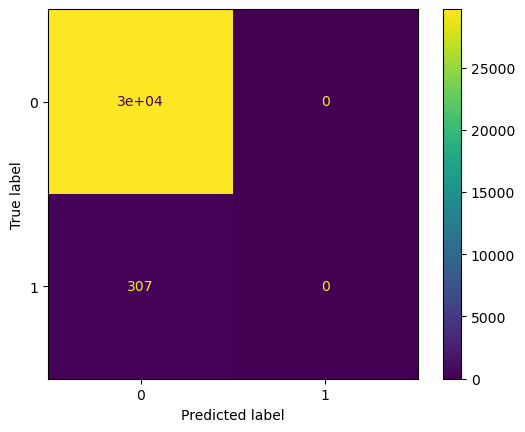

In [24]:
cm = confusion_matrix(Y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm).plot();

In [25]:
print(classification_report(Y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     29693
           1       0.00      0.00      0.00       307

    accuracy                           0.99     30000
   macro avg       0.49      0.50      0.50     30000
weighted avg       0.98      0.99      0.98     30000



## Observaciones 

* Este modelo tiene un buen rendimiento acertando las predicciones en general, sin embargo esto para los casos negativos del fraude, esto se debe al desbalance de los datos. Esta es la razon del sesgo hacia los casos negativos, osea no fraudulente. Vemos que tiene una nivel acierto perfecto para los casos reales negativos, perfecto en ese aspecto.
* En cuanto a los casos positivos vemos que tiene metricas pesimas, osea no se puede utilizar para predecir ni detectar casos reales de esta clase. Se puede observar que solamente habian 307 casos de esta en relacion con la otra. Estos datos eran lo esperados.

### Oversampling dataset
Entrena el modelo con el dataset sobre el que aplicaste la técnica de oversampling y analiza sus métricas. ¿Qué observas? ¿Qué conclusiones puedes extraer?

In [26]:
#Definiendo la instancia del modelo y los valores de los hiperparametros
rfr1 = RandomForestClassifier(random_state=42)
param_grid = {
    "n_estimators": [50, 100, 200, 500],        # cantidad de árboles en el bosque :contentReference[oaicite:2]{index=2}
    "max_depth": [None, 5, 10, 20],             # profundidad máxima de cada árbol :contentReference[oaicite:3]{index=3}
    "max_features": [None, "sqrt", "log2", 0.3] # cantidad de características a usar en cada split :contentReference[oaicite:4]{index=4}
}

In [27]:
# Configurar GridSearchCV para el conjuntos con Oversampling
rfr_deep1 = GridSearchCV(
    estimator=rfr1,
    param_grid=param_grid,
    cv=3,
    scoring='roc_auc',      # métrica ideal si hay desbalance
    n_jobs=-1,
    verbose=1
)

In [28]:
# Entrenando el modelo 
rfr_deep1.fit(X_over, Y_over)

Fitting 3 folds for each of 64 candidates, totalling 192 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [None, 5, 10, 20],
                         'max_features': [None, 'sqrt', 'log2', 0.3],
                         'n_estimators': [50, 100, 200, 500]},
             scoring='roc_auc', verbose=1)

In [29]:
print("Mejores parámetros:", rfr_deep1.best_params_)
print("Mejor puntuación roc_auc:", rfr_deep1.best_score_)

Mejores parámetros: {'max_depth': None, 'max_features': None, 'n_estimators': 500}
Mejor puntuación roc_auc: 1.0


In [30]:
# Crearemos otro objeto con los mejores paramentros 
rfr_model1 = RandomForestClassifier(n_estimators = 50, max_depth = None, max_features = None )

In [31]:
# Entrenamos el modelo con el objeto con los mejores parametros
rfr_model1.fit(X_over, Y_over)

RandomForestClassifier(max_features=None, n_estimators=50)

In [32]:
# Realizando algunas predicciones con los datos pruebas 
y_pred1 = rfr_model1.predict(X_test)
y_pred1[0:5]# Realizando algunas predicciones con los datos pruebas 


array([0, 0, 0, 0, 0], dtype=int64)

In [33]:
# Metricas para medir el rendimiento del modelo 
accuracy = accuracy_score(Y_test, y_pred1)
print("Accuracy:", accuracy)
precision = precision_score(Y_test, y_pred1)
print("Precision:", precision)
recall = recall_score(Y_test, y_pred1)
print("Recall:", recall)

Accuracy: 0.9875666666666667
Precision: 0.0875
Recall: 0.02280130293159609


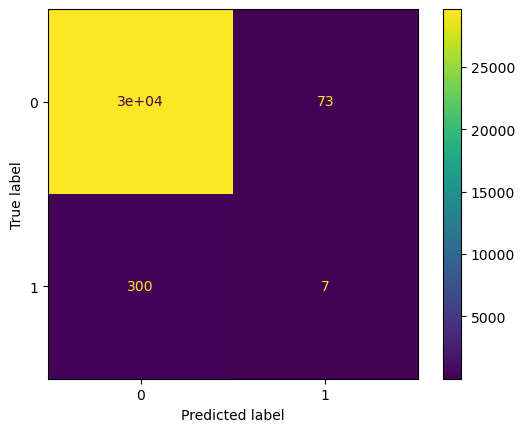

In [34]:
cm = confusion_matrix(Y_test, y_pred1)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()

In [35]:
print(classification_report(Y_test, y_pred1))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     29693
           1       0.09      0.02      0.04       307

    accuracy                           0.99     30000
   macro avg       0.54      0.51      0.51     30000
weighted avg       0.98      0.99      0.98     30000



## Observaciones

* Este modelo es practicamente identico al anterior, lo unico que con este metodo, los casos positivos mejoraron un poco en comparacion co el 
modelo anterior ya que un nivel acierto de un 0.00. En cuando a los casos reales practicamente no mejoro nada.


### Undersampling dataset
Entrena el modelo con el dataset sobre el que aplicaste la técnica de undersampling y analiza sus métricas. ¿Qué observas? ¿Qué conclusiones puedes extraer?

In [36]:
#Definiendo la instancia del modelo y los valores de los hiperparametros
rfr2 = RandomForestClassifier(random_state=42)
param_grid = {
    "n_estimators": [50, 100, 200, 500],        # cantidad de árboles en el bosque :contentReference[oaicite:2]{index=2}
    "max_depth": [None, 5, 10, 20],             # profundidad máxima de cada árbol :contentReference[oaicite:3]{index=3}
    "max_features": [None, "sqrt", "log2", 0.3] # cantidad de características a usar en cada split :contentReference[oaicite:4]{index=4}
}

In [37]:
# Configurar GridSearchCV para el conjuntos con Undesampling
rfr_deep2 = GridSearchCV(
    estimator=rfr2,
    param_grid=param_grid,
    cv=3,
    scoring='roc_auc',      # métrica ideal si hay desbalance
    n_jobs=-1,
    verbose=1
)

In [38]:
# Entrenando el modelo con los datos de undesampling 
rfr_deep2.fit(X_under, Y_under)

Fitting 3 folds for each of 64 candidates, totalling 192 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [None, 5, 10, 20],
                         'max_features': [None, 'sqrt', 'log2', 0.3],
                         'n_estimators': [50, 100, 200, 500]},
             scoring='roc_auc', verbose=1)

In [39]:
print("Mejores parámetros:", rfr_deep2.best_params_)
print("Mejor puntuación roc_auc:", rfr_deep2.best_score_)

Mejores parámetros: {'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 500}
Mejor puntuación roc_auc: 0.8475265799793288


In [40]:
# Crearemos otro objeto con los mejores paramentros 
rfr_model2 = RandomForestClassifier(n_estimators = 500, max_depth = 10, max_features = "sqrt" )

In [41]:
# Entrenamos el modelo con el objeto con los mejores parametros
rfr_model2.fit(X_under, Y_under)

RandomForestClassifier(max_depth=10, n_estimators=500)

In [42]:
# Realizando algunas predicciones con los datos pruebas 
y_pred2 = rfr_model2.predict(X_test)
y_pred2[0:5]# Realizando algunas predicciones con los datos pruebas 


array([0, 0, 1, 0, 0], dtype=int64)

In [43]:
# Metricas para medir el rendimiento del modelo 
accuracy = accuracy_score(Y_test, y_pred2)
print("Accuracy:", accuracy)
precision = precision_score(Y_test, y_pred2)
print("Precision:", precision)
recall = recall_score(Y_test, y_pred2)
print("Recall:", recall)

Accuracy: 0.7936333333333333
Precision: 0.03742138364779874
Recall: 0.7752442996742671


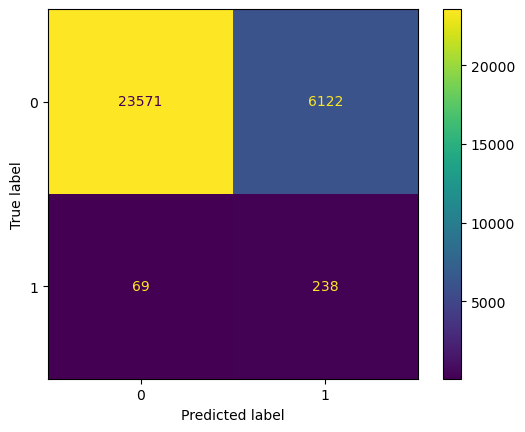

In [44]:
cm = confusion_matrix(Y_test, y_pred2)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()

In [45]:
print(classification_report(Y_test, y_pred2))

              precision    recall  f1-score   support

           0       1.00      0.79      0.88     29693
           1       0.04      0.78      0.07       307

    accuracy                           0.79     30000
   macro avg       0.52      0.78      0.48     30000
weighted avg       0.99      0.79      0.88     30000



## Observaciones 

* En las clases negativas vemos que todo permenacer igual, sin embargo en la clase positiva para los casos reales 
mejoro significativamente, nos dice que 10 casos reales predice 8 correctamente, este dato es muy importante dada la naturaleza del 
caso de uso. Tambien vemmos que la precision a nivel general empeoro, vemos paso de ser perfecto a acertar 8 de 10 casos. 
Otra cosa que tenemos que aclarar es que los casos negativos reales empeoro, paso de ser perfecta a detectar 8 de 10.

### SMOTE dataset
Entrena el modelo con el dataset sobre el que aplicaste la técnica de SMOTE y analiza sus métricas. ¿Qué observas? ¿Qué conclusiones puedes extraer?

In [57]:
#Definiendo la instancia del modelo y los valores de los hiperparametros
rfr3 = RandomForestClassifier(random_state=42)
param_grid = {
    "n_estimators": [50, 100, 200, 500],        # cantidad de árboles en el bosque :contentReference[oaicite:2]{index=2}
    "max_depth": [None, 5, 10, 20],             # profundidad máxima de cada árbol :contentReference[oaicite:3]{index=3}
    "max_features": [None, "sqrt", "log2", 0.3] # cantidad de características a usar en cada split :contentReference[oaicite:4]{index=4}
}

In [58]:
# Configurar GridSearchCV para el conjuntos con SMOTE
rfr_deep3 = GridSearchCV(
    estimator=rfr3,
    param_grid=param_grid,
    cv=3,
    scoring='roc_auc',      # métrica ideal si hay desbalance
    n_jobs=-1,
    verbose=1
)

In [59]:
# Entrenando el modelo con los datos de SMOTE
rfr_deep3.fit(X_resampled, Y_resampled)

Fitting 3 folds for each of 64 candidates, totalling 192 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [None, 5, 10, 20],
                         'max_features': [None, 'sqrt', 'log2', 0.3],
                         'n_estimators': [50, 100, 200, 500]},
             scoring='roc_auc', verbose=1)

In [60]:
print("Mejores parámetros:", rfr_deep3.best_params_)
print("Mejor puntuación roc_auc:", rfr_deep3.best_score_)

Mejores parámetros: {'max_depth': None, 'max_features': 'sqrt', 'n_estimators': 500}
Mejor puntuación roc_auc: 0.9998163442299294


In [62]:
# Crearemos otro objeto con los mejores paramentros 
rfr_model3 = RandomForestClassifier(n_estimators = 500, max_depth = None, max_features = "sqrt" )

In [63]:
# Entrenamos el modelo con el objeto con los mejores parametros
rfr_model3.fit(X_resampled, Y_resampled)

RandomForestClassifier(n_estimators=500)

In [64]:
# Realizando algunas predicciones con los datos pruebas 
y_pred3 = rfr_model3.predict(X_test)
y_pred2[0:5]# Realizando algunas predicciones con los datos pruebas 


array([0, 0, 1, 0, 0], dtype=int64)

In [65]:
# Metricas para medir el rendimiento del modelo 
accuracy = accuracy_score(Y_test, y_pred3)
print("Accuracy:", accuracy)
precision = precision_score(Y_test, y_pred3)
print("Precision:", precision)
recall = recall_score(Y_test, y_pred3)
print("Recall:", recall)

Accuracy: 0.9885333333333334
Precision: 0.17543859649122806
Recall: 0.03257328990228013


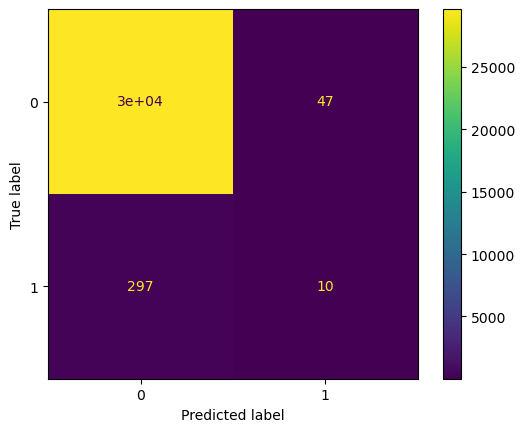

In [66]:
cm = confusion_matrix(Y_test, y_pred3)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()

In [67]:
print(classification_report(Y_test, y_pred3))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     29693
           1       0.18      0.03      0.05       307

    accuracy                           0.99     30000
   macro avg       0.58      0.52      0.52     30000
weighted avg       0.98      0.99      0.98     30000



## Observaciones 

* En este caso se puede que los aciertos de los casos positivos reales disminuyeron, dado que con la tecnica anterior habian aumentado. Se puede decir que con esta tecnica el modelo no mejoro con los casos los casos postivos, osea con los que relamente queremos acertar. Entiendo que debe haner una forma de mejorar estos resultados con algunos hiperparametros de estas tecnicas para mejorar su rendimiento.

* En cuanto al acierto general de sus predicciones es muy pero sabemos que esta sesgados por los valores negativos, los cuales se puede decir que tienen una metrica perfecta.

#### Conclusiones

¿Qué conclusiones sacas tras aplicar el modelo utilizando las diferentes técnicas?

* Se puede concluir que la tecnica que mejor resultado arrojo fue Undersampling debido a que fue la que mejor acierto tenia para los casos positivos reales, de cada 10 casos acertaba 8. Aunque los aciertos a nivel general no fue la mejor, en este caso en particular prefiero aumentar los aciertos con los casos reales positivos de fraudes que aumentar los aciertos de los casos negativos reales. A mi entender esta fue la mejor tecnica por las razones mencionadas.

* Las demas tecnicas aunque tenian mejores rendimientos a nivel general y para la clase 0, no eran para nada utilices en los casos positivos reales, que es lo que amerita este caso por su naturaleza de fraude.

# Clustering

En esta sección queremos segmentar los tipos de transacciones fraudulentas y no fraudulentas para analizar si hay tipos de transacciones con patrones comunes.
Para ello aplica un algoritmo de clustering. Tal y como aprendimos en la Unidad 2, utilizaremos k-Means.

Elimina la variable objetivo para la segmentación.

#### Dataset original

In [3]:
#Lectura de datos
df_cluster = pd.read_csv('base.csv', sep = ',')

In [4]:
df_cluster.head()

,fraud_bool,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,payment_type,zip_count_4w,velocity_6h,velocity_24h,velocity_4w,bank_branch_count_8w,date_of_birth_distinct_emails_4w,employment_status,credit_risk_score,email_is_free,housing_status,phone_home_valid,phone_mobile_valid,bank_months_count,has_other_cards,proposed_credit_limit,foreign_request,source,session_length_in_minutes,device_os,keep_alive_session,device_distinct_emails_8w,device_fraud_count,month
0,0,0.3,0.986506,NaN,25.0,40,0.006735,102.453711,AA,1059,13096.035018,7850.955007,6742.080561,5,5,CB,163.0,1.0,BC,0,1,9.0,0,1500.0,0,INTERNET,16.224843,linux,1,1,0,0
1,0,0.8,0.617426,NaN,89.0,20,0.010095,-0.849551,AD,1658,9223.283431,5745.251481,5941.664859,3,18,CA,154.0,1.0,BC,1,1,2.0,0,1500.0,0,INTERNET,3.363854,other,1,1,0,0
2,0,0.8,0.996707,9.0,14.0,40,0.012316,-1.490386,AB,1095,4471.472149,5471.988958,5992.555113,15,11,CA,89.0,1.0,BC,0,1,30.0,0,200.0,0,INTERNET,22.730559,windows,0,1,0,0
3,0,0.6,0.475100,11.0,14.0,30,0.006991,-1.863101,AB,3483,14431.993621,6755.344479,5970.336831,11,13,CA,90.0,1.0,BC,0,1,1.0,0,200.0,0,INTERNET,15.215816,linux,1,1,0,0
4,0,0.9,0.842307,NaN,29.0,40,5.742626,47.152498,AA,2339,7601.511579,5124.046930,5940.734212,1,6,CA,91.0,0.0,BC,1,1,26.0,0,200.0,0,INTERNET,3.743048,other,0,1,0,0


In [5]:
df_cluster.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 32 columns):
 #   Column                            Non-Null Count    Dtype  
---  ------                            --------------    -----  
 0   fraud_bool                        1000000 non-null  int64  
 1   income                            1000000 non-null  float64
 2   name_email_similarity             1000000 non-null  float64
 3   prev_address_months_count         287080 non-null   float64
 4   current_address_months_count      995746 non-null   float64
 5   customer_age                      1000000 non-null  int64  
 6   days_since_request                1000000 non-null  float64
 7   intended_balcon_amount            1000000 non-null  float64
 8   payment_type                      1000000 non-null  object 
 9   zip_count_4w                      1000000 non-null  int64  
 10  velocity_6h                       1000000 non-null  float64
 11  velocity_24h                      1000

In [6]:
# Elimiando la variable objetivo
df_cluster.drop('fraud_bool', axis = 1, inplace = True)

In [7]:
# Definiendo la instancias de para podor normalizar los datos 
scaler =  MinMaxScaler()

In [8]:
# Transformando las columnas para el lcuster 
df_cluster[['income','proposed_credit_limit']] = scaler.fit_transform(df_cluster[['income','proposed_credit_limit']])

Aplica el método del codo para obtener el número óptimo de clusters previamente

In [9]:
# Definiendo rango de valores
Ks = range(2, 10)

In [10]:
# Definiendo iteracion para realizar el metodo del codo para determianr la cantidad optima de cluster 
intertias = []

for k in Ks:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(df_cluster[['income','proposed_credit_limit']])
    intertias.append(kmeans.inertia_)

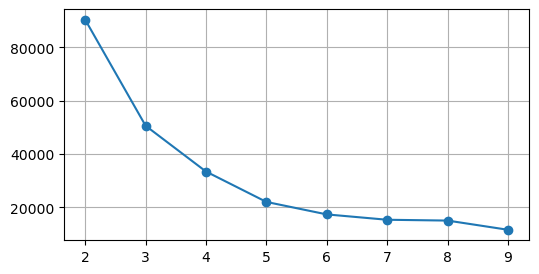

In [11]:
plt.figure(figsize=(6,3))

plt.plot(Ks, intertias, marker='o')
plt.grid()
plt.show()

In [ ]:
#silhouette_avg = silhouette_score(df_cluster[['income','customer_age','has_other_cards']], kmeans.labels_ )
#silhouette_avg

## Observaciones 

* De acuerdo con el metodo del codo el numero optimo de cluster son tres. Utilizamos dos variables, luego de noramlizarlas, 
  para poder aplicar este metodo.Se puede ver en la grafica, claramente, que en ese punto la grafico muestra como lo suma 
  de los errores cuadraticos tiene a ser menos prenuciada y por tanto se ve claramente que agregar otro cluster no 
  reduce significativamente la suma de errores.

Aplica el algoritmo k_means. Para cada conjunto de datos printea el número de registros que pertenen a dicho cluster y estadísticos de cada variable numérica. Para las variables binarias puedes graficar la cantidad de 0s y 1s por cluster.
¿Qué observas? ¿Tienen los clusters un tamaño similar? 

*Idea*: Puedes guardar la media por ejemplo de cada variable por cluster en un dataframe, de forma que tengas todos los valores agrupados y se más fácil de comparar.

In [12]:
# Definiendo el modelo con el numero de cluster optimo recomendado por el metodo dlecodgo
kmeans1 = KMeans(n_clusters=3, random_state=1993)

In [13]:
kmeans1.fit(df_cluster[['income','proposed_credit_limit']])

KMeans(n_clusters=3, random_state=1993)

In [14]:
df_cluster['labels'] = kmeans1.predict(df_cluster[['income','proposed_credit_limit']])

In [15]:
#Obtenemos los centroides de los clusters asignados por k-Means
centroids1 = kmeans1.cluster_centers_
centroids1

array([[0.85444073, 0.0608888 ],
       [0.18262433, 0.0520424 ],
       [0.65004038, 0.63574876]])

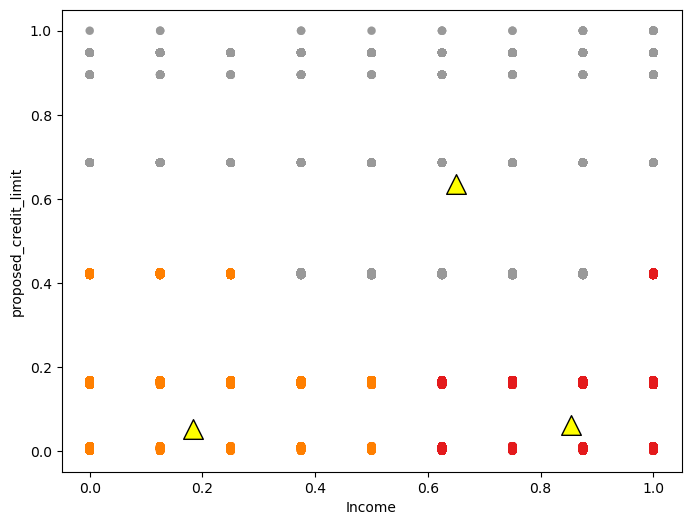

In [16]:
fig, ax = plt.subplots(figsize=(8, 6))

# Puntos del cluster
ax.scatter(
    df_cluster['income'],
    df_cluster['proposed_credit_limit'],
    c=df_cluster['labels'],
    cmap=plt.cm.Set1,
    linewidths=0.1
)

# Centroides en 3D
ax.scatter(
    centroids1[:,0],
    centroids1[:,1],
    marker='^',
    color='yellow',
    s=200,       # tamaño de marcador
    edgecolor='k'
)

ax.set_xlabel('Income')
ax.set_ylabel('proposed_credit_limit')


plt.show()

In [17]:
df_cluster['labels'].value_counts()

labels
0    452521
1    351221
2    196258
Name: count, dtype: int64

In [18]:
df_cluster['labels'].value_counts(normalize = True)

labels
0    0.452521
1    0.351221
2    0.196258
Name: proportion, dtype: float64

In [20]:
df_cluster[df_cluster['labels']==0].describe()

,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,zip_count_4w,velocity_6h,velocity_24h,velocity_4w,bank_branch_count_8w,date_of_birth_distinct_emails_4w,credit_risk_score,email_is_free,phone_home_valid,phone_mobile_valid,bank_months_count,has_other_cards,proposed_credit_limit,foreign_request,session_length_in_minutes,keep_alive_session,device_distinct_emails_8w,device_fraud_count,month,labels
count,452521.000000,452521.000000,140862.000000,450272.000000,452521.000000,4.525210e+05,452521.000000,452521.000000,452521.000000,452521.000000,452521.000000,452521.000000,452521.000000,377043.000000,451161.000000,452521.000000,452521.000000,341728.000000,452521.000000,452521.000000,452521.000000,451820.000000,452521.000000,452521.000000,452521.0,452521.000000,452521.0
mean,0.854441,0.474448,60.948006,77.954792,33.979904,1.121048e+00,9.171357,1508.369738,5446.284608,4622.113864,4739.072525,185.346117,9.346976,120.019133,0.521829,0.424433,0.896984,14.809743,0.235571,0.060889,0.024839,7.193311,0.563724,1.017827,0.0,3.596324,0.0
std,0.142650,0.292484,62.285490,83.203385,11.638840,5.689711e+00,19.945225,957.261025,2899.267442,1467.718038,926.233716,461.274257,4.909617,58.081864,0.499524,0.494257,0.303980,11.552052,0.424356,0.106658,0.155633,7.706173,0.495923,0.173776,0.0,2.227488,0.0
min,0.625000,0.000001,5.000000,0.000000,10.000000,4.036860e-09,-15.530555,1.000000,-123.460329,1320.283991,2864.909845,0.000000,0.000000,-168.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000872,0.000000,-1.000000,0.0,0.000000,0.0
25%,0.750000,0.202444,26.000000,17.000000,30.000000,7.299622e-03,-1.160677,873.000000,3296.773802,3435.711742,4227.903711,1.000000,6.000000,83.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.005236,0.000000,2.873747,0.000000,1.000000,0.0,2.000000,0.0
50%,0.875000,0.460729,35.000000,46.000000,30.000000,1.542544e-02,-0.805138,1222.000000,5039.327502,4581.254447,4798.883509,10.000000,9.000000,116.000000,1.000000,0.000000,1.000000,15.000000,0.000000,0.005236,0.000000,4.946963,1.000000,1.000000,0.0,4.000000,0.0
75%,1.000000,0.741137,78.000000,112.000000,40.000000,2.672047e-02,12.460463,1863.000000,7375.318532,5584.911908,5348.791620,26.000000,12.000000,155.000000,1.000000,1.000000,1.000000,28.000000,0.000000,0.162304,0.000000,8.494999,1.000000,1.000000,0.0,6.000000,0.0
max,1.000000,0.999999,383.000000,428.000000,90.000000,7.845690e+01,112.452078,6700.000000,16640.749743,9483.255648,6988.564717,2371.000000,39.000000,371.000000,1.000000,1.000000,1.000000,32.000000,1.000000,0.424084,1.000000,85.899143,1.000000,2.000000,0.0,7.000000,0.0


In [24]:
df_cluster[df_cluster['labels']==0].describe(include = 'object')

,payment_type,employment_status,housing_status,source,device_os
count,452521,452521,452521,452521,452521
unique,5,7,7,2,5
top,AB,CA,BC,INTERNET,other
freq,160062,329422,189438,449474,164244


In [22]:
df_cluster[df_cluster['labels']==1].describe()

,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,zip_count_4w,velocity_6h,velocity_24h,velocity_4w,bank_branch_count_8w,date_of_birth_distinct_emails_4w,credit_risk_score,email_is_free,phone_home_valid,phone_mobile_valid,bank_months_count,has_other_cards,proposed_credit_limit,foreign_request,session_length_in_minutes,keep_alive_session,device_distinct_emails_8w,device_fraud_count,month,labels
count,351221.000000,351221.000000,101787.000000,349722.000000,351221.000000,3.512210e+05,351221.000000,351221.000000,351221.000000,351221.000000,351221.000000,351221.000000,351221.00000,292821.000000,350118.000000,351221.000000,351221.000000,252184.000000,351221.000000,351221.000000,351221.000000,350311.000000,351221.000000,351221.000000,351221.0,351221.000000,351221.0
mean,0.182624,0.498195,58.747777,86.725528,31.532454,1.244031e+00,6.972531,1658.620891,5961.711365,4897.850435,4931.313548,178.108351,9.89194,104.652375,0.545653,0.398729,0.888102,15.623224,0.171798,0.052042,0.022493,8.040814,0.598264,1.021454,0.0,3.095108,1.0
std,0.183006,0.285743,63.755339,88.973087,12.231012,5.834643e+00,17.899352,1043.238088,3028.685089,1456.345651,894.663090,457.291775,5.12418,58.147808,0.497912,0.489637,0.315242,11.332021,0.377205,0.109305,0.148280,8.301523,0.490250,0.193639,0.0,2.139965,0.0
min,0.000000,0.000030,6.000000,0.000000,10.000000,6.365529e-08,-14.383932,2.000000,-139.096768,1300.307314,2825.748405,0.000000,0.00000,-170.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.002298,0.000000,-1.000000,0.0,0.000000,1.0
25%,0.000000,0.236097,25.000000,19.000000,20.000000,7.422885e-03,-1.249874,934.000000,3755.201380,3782.558243,4299.304372,1.000000,6.00000,67.000000,0.000000,0.000000,1.000000,2.000000,0.000000,0.005236,0.000000,3.417928,0.000000,1.000000,0.0,1.000000,1.0
50%,0.125000,0.500006,32.000000,53.000000,30.000000,1.570692e-02,-0.912123,1328.000000,5623.872826,4888.331108,5023.723599,9.000000,9.00000,102.000000,1.000000,0.000000,1.000000,15.000000,0.000000,0.005236,0.000000,5.403237,1.000000,1.000000,0.0,3.000000,1.0
75%,0.375000,0.749816,61.000000,124.000000,40.000000,2.765703e-02,-0.288893,2120.000000,7941.206726,5845.086140,5529.013325,22.000000,13.00000,138.000000,1.000000,1.000000,1.000000,28.000000,0.000000,0.005236,0.000000,9.455453,1.000000,1.000000,0.0,5.000000,1.0
max,0.500000,0.999999,377.000000,425.000000,90.000000,7.598933e+01,112.325123,6676.000000,16715.565404,9486.025796,6964.040026,2385.000000,39.00000,378.000000,1.000000,1.000000,1.000000,32.000000,1.000000,0.424084,1.000000,83.213536,1.000000,2.000000,0.0,7.000000,1.0


In [25]:
df_cluster[df_cluster['labels']==1].describe(include = 'object')

,payment_type,employment_status,housing_status,source,device_os
count,351221,351221,351221,351221,351221
unique,5,7,7,2,5
top,AB,CA,BC,INTERNET,linux
freq,131409,246867,123600,348416,130675


In [23]:
df_cluster[df_cluster['labels']==2].describe()

,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,zip_count_4w,velocity_6h,velocity_24h,velocity_4w,bank_branch_count_8w,date_of_birth_distinct_emails_4w,credit_risk_score,email_is_free,phone_home_valid,phone_mobile_valid,bank_months_count,has_other_cards,proposed_credit_limit,foreign_request,session_length_in_minutes,keep_alive_session,device_distinct_emails_8w,device_fraud_count,month,labels
count,196258.000000,196258.000000,44431.000000,195752.000000,196258.000000,1.962580e+05,196258.000000,196258.000000,196258.000000,196258.000000,196258.000000,196258.000000,196258.000000,163365.000000,195683.000000,196258.000000,196258.000000,152453.000000,196258.000000,196258.000000,196258.000000,195854.000000,196258.000000,196258.000000,196258.0,196258.000000,196258.0
mean,0.650040,0.530017,64.515091,108.103294,36.877987,4.151565e-01,10.508450,1567.225688,5639.822175,4881.077202,4992.475731,193.283566,9.169481,203.175093,0.520045,0.432951,0.875643,13.722964,0.285583,0.635749,0.031092,7.557099,0.569286,1.013808,0.0,2.925715,2.0
std,0.321156,0.283477,66.955562,95.178546,11.753284,3.396568e+00,24.224459,1032.918607,3174.830941,1514.697743,916.728030,459.819148,5.109313,64.691713,0.499599,0.495485,0.329989,11.695458,0.451693,0.123028,0.173566,8.230885,0.495177,0.172392,0.0,2.198466,0.0
min,0.000000,0.000010,6.000000,0.000000,10.000000,3.112791e-08,-11.652876,1.000000,-170.603072,1368.315995,2930.765607,0.000000,0.000000,-164.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.418848,0.000000,0.003262,0.000000,-1.000000,0.0,0.000000,2.0
25%,0.375000,0.276517,26.000000,32.000000,30.000000,6.589999e-03,-1.093499,879.000000,3207.525486,3680.199298,4318.124665,1.000000,5.000000,173.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.685864,0.000000,3.104704,0.000000,1.000000,0.0,1.000000,2.0
50%,0.750000,0.541612,35.000000,75.000000,40.000000,1.380476e-02,-0.749334,1249.000000,5394.187447,4829.123723,5013.706392,10.000000,8.000000,208.000000,1.000000,0.000000,1.000000,11.000000,0.000000,0.685864,0.000000,5.029736,1.000000,1.000000,0.0,3.000000,2.0
75%,0.875000,0.788020,86.000000,170.000000,50.000000,2.353940e-02,-0.074670,1871.000000,7816.203329,5910.442351,5551.225054,28.000000,13.000000,244.000000,1.000000,1.000000,1.000000,26.000000,1.000000,0.685864,0.000000,8.782599,1.000000,1.000000,0.0,5.000000,2.0
max,1.000000,0.999999,374.000000,418.000000,90.000000,7.533657e+01,112.956928,6568.000000,16665.359533,9506.896596,6994.764201,2380.000000,37.000000,389.000000,1.000000,1.000000,1.000000,32.000000,1.000000,1.000000,1.000000,82.254078,1.000000,2.000000,0.0,7.000000,2.0


In [26]:
df_cluster[df_cluster['labels']==2].describe(include = 'object')

,payment_type,employment_status,housing_status,source,device_os
count,196258,196258,196258,196258,196258
unique,5,7,7,2,5
top,AB,CA,BA,INTERNET,windows
freq,79083,153963,69280,195062,65855


In [ ]:
# No calcule la silhoutte debido a que dura mucho realizar el calculo 
#silhouette_avg = silhouette_score(df_cluster[['income','customer_age','has_other_cards']], kmeans.labels_ )
#silhouette_avg

## Observaciones 

* Grupo 0: Es el grupo mas grande, tiene un 45% del total. Su nivel de ingresos es el mas grande de los tres, tiene unas edad promedio de 37 anos, menos del 75% de este grupo no han tenido otra tarjeta, con ninguno de sus dispositivo han realizado algun fraude y as del 90% realizo a solicitud por la web.

* Grupo 1: es el segundo grupo mas grande, tiene el nivel ingresos mas bajo de todos, tienen una edad promedio de 31 anos, duran en promedio 8 minutos sus sesioens, mas del 90% hizo su solicitud por la web, casi el 50% de ellos usan el sistema oprativo linux.

* Grupo 2: es el grupo mas pequeno de los tres, es el segundo mayor nivel de ingresos, tienen una de edad promedio de 37, es el que tiene mejor puntuacion crediticia y utilizan el sistema operativo que mas utilizan es window. 

#### Sólo fraude

Ahora realiza la clusterización sólo seleccionando las transacciones fraudulentas

In [48]:
df_cluster_f = pd.read_csv('base.csv', sep = ',')

In [49]:
df_cluster_f = df_cluster_f[df_cluster_f['fraud_bool'] == 1]
df_cluster_f

,fraud_bool,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,payment_type,zip_count_4w,velocity_6h,velocity_24h,velocity_4w,bank_branch_count_8w,date_of_birth_distinct_emails_4w,employment_status,credit_risk_score,email_is_free,housing_status,phone_home_valid,phone_mobile_valid,bank_months_count,has_other_cards,proposed_credit_limit,foreign_request,source,session_length_in_minutes,device_os,keep_alive_session,device_distinct_emails_8w,device_fraud_count,month
43,1,0.9,0.570800,NaN,157.0,60,0.005908,35.337538,AA,4079,8139.265753,4312.230612,6341.431598,2,17,CA,131.0,1.0,BA,1,1,30.0,0,1500.0,0,INTERNET,4.036394,windows,1,1,0,0
140,1,0.1,0.993219,NaN,67.0,20,0.015331,92.120139,AA,1192,8330.727428,6708.346918,6709.436651,37,6,CA,79.0,1.0,BB,0,1,25.0,0,1500.0,0,INTERNET,12.928072,windows,0,1,0,0
284,1,0.8,0.794351,NaN,376.0,60,17.925951,41.422110,AA,815,9747.407396,6902.019628,6467.154127,46,3,CC,NaN,1.0,BA,1,0,28.0,0,1500.0,0,INTERNET,2.550167,linux,0,1,0,0
314,1,0.7,0.090000,NaN,58.0,50,0.004134,-1.244047,AD,4011,8036.901841,5794.624929,6333.335164,2,6,CA,177.0,1.0,BA,0,1,27.0,0,1500.0,0,INTERNET,3.500856,windows,0,1,0,0
561,1,0.9,0.998248,31.0,45.0,30,0.010165,33.067538,AA,525,6883.814598,3655.042385,4327.215795,16,12,CA,273.0,1.0,BA,0,1,1.0,1,2000.0,0,INTERNET,44.536211,windows,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999862,1,0.3,0.346834,NaN,13.0,20,0.007084,-0.994025,AC,692,4606.385548,3048.936631,3008.145870,0,9,CE,NaN,1.0,BA,0,1,NaN,0,200.0,0,INTERNET,23.525141,windows,1,1,0,7
999879,1,0.7,0.161950,289.0,209.0,40,0.008195,-0.837462,AC,679,1213.608342,2867.661501,3123.982404,1,10,CA,272.0,0.0,BA,1,0,NaN,0,2000.0,0,INTERNET,9.366778,windows,0,1,0,7
999923,1,0.4,0.098119,NaN,139.0,30,0.028858,-1.383748,AB,345,2675.999910,3928.932950,3026.587206,1,8,CB,158.0,0.0,BA,1,0,1.0,0,500.0,0,INTERNET,2.363665,windows,0,1,0,7
999938,1,0.8,0.830047,NaN,73.0,40,0.009757,-1.439571,AC,623,2389.443697,2925.272333,3077.924174,0,1,CA,295.0,1.0,BA,0,1,NaN,0,1900.0,0,INTERNET,1.596140,linux,0,1,0,7


Aplica el método del codo para obtener el número óptimo de clusters previamente

In [50]:
# Transformando las columnas para el lcuster 
df_cluster_f[['income','proposed_credit_limit']] = scaler.fit_transform(df_cluster_f[['income','proposed_credit_limit']])

In [51]:
# Definiendo rango de valores
Ks = range(2, 10)

In [52]:
# Definiendo iteracion para realizar el metodo del codo para determianr la cantidad optima de cluster 
intertias = []

for k in Ks:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(df_cluster_f[['income','proposed_credit_limit']])
    intertias.append(kmeans.inertia_)

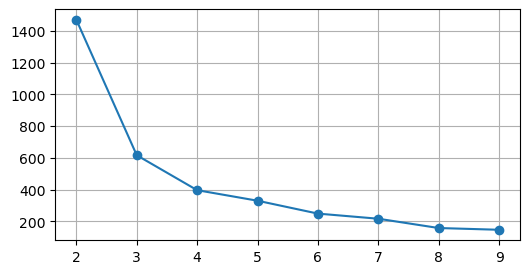

In [53]:
plt.figure(figsize=(6,3))

plt.plot(Ks, intertias, marker='o')
plt.grid()
plt.show()

## Observaciones

* Al igual que el anterior, de acuerdo con el metodo del codo, la cantidad optima de cluster es 3.

Aplica el algoritmo k_means. Para cada conjunto de datos printea el número de registros que pertenen a dicho cluster y estadísticos de cada variable numérica. Para las variables binarias puedes graficar la cantidad de 0s y 1s por cluster.
¿Qué observas? ¿Tienen los clusters un tamaño similar? 

*Idea*: Puedes guardar la media por ejemplo de cada variable por cluster en un dataframe, de forma que tengas todos los valores agrupados y se más fácil de comparar.

In [45]:
# Definiendo el modelo con el numero de cluster optimo recomendado por el metodo dlecodgo
kmeans2 = KMeans(n_clusters=3, random_state=1993)

In [54]:
kmeans2.fit(df_cluster_f[['income','proposed_credit_limit']])

KMeans(n_clusters=3, random_state=1993)

In [55]:
df_cluster_f['labels'] = kmeans2.predict(df_cluster_f[['income','proposed_credit_limit']])

In [56]:
#Obtenemos los centroides de los clusters asignados por k-Means
centroids2 = kmeans2.cluster_centers_
centroids2

array([[0.87434969, 0.0482123 ],
       [0.87516873, 0.68604762],
       [0.15343273, 0.21080621]])

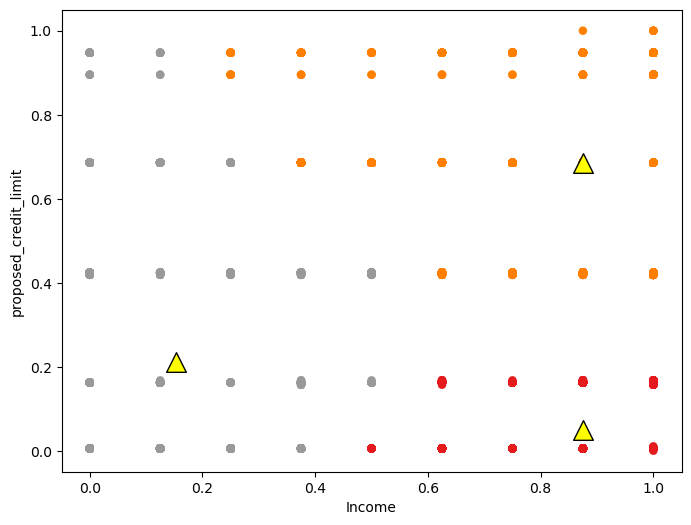

In [57]:
fig, ax = plt.subplots(figsize=(8, 6))

# Puntos del cluster
ax.scatter(
    df_cluster_f['income'],
    df_cluster_f['proposed_credit_limit'],
    c=df_cluster_f['labels'],
    cmap=plt.cm.Set1,
    linewidths=0.1
)

# Centroides en 3D
ax.scatter(
    centroids2[:,0],
    centroids2[:,1],
    marker='^',
    color='yellow',
    s=200,       # tamaño de marcador
    edgecolor='k'
)

ax.set_xlabel('Income')
ax.set_ylabel('proposed_credit_limit')


plt.show()

In [58]:
df_cluster_f['labels'].value_counts()

labels
1    4445
0    4421
2    2163
Name: count, dtype: int64

In [59]:
df_cluster_f['labels'].value_counts(normalize = True)

labels
1    0.403028
0    0.400852
2    0.196119
Name: proportion, dtype: float64

In [60]:
df_cluster_f[df_cluster_f['labels']==0].describe()

,fraud_bool,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,zip_count_4w,velocity_6h,velocity_24h,velocity_4w,bank_branch_count_8w,date_of_birth_distinct_emails_4w,credit_risk_score,email_is_free,phone_home_valid,phone_mobile_valid,bank_months_count,has_other_cards,proposed_credit_limit,foreign_request,session_length_in_minutes,keep_alive_session,device_distinct_emails_8w,device_fraud_count,month,labels
count,4421.0,4421.000000,4421.000000,408.000000,4413.000000,4421.000000,4421.000000,4421.000000,4421.000000,4421.000000,4421.000000,4421.000000,4421.000000,4421.000000,3670.000000,4407.000000,4421.000000,4421.000000,2817.000000,4421.000000,4421.000000,4421.000000,4416.000000,4421.000000,4421.000000,4421.0,4421.000000,4421.0
mean,1.0,0.874350,0.360436,80.968137,102.487424,39.726306,1.489280,4.586098,1627.064465,5205.936204,4581.805272,4675.161865,133.220991,7.665008,135.929155,0.661675,0.248586,0.863606,17.868300,0.074191,0.048212,0.048179,7.882050,0.352409,1.074418,0.0,3.758878,0.0
std,0.0,0.156889,0.287453,80.065308,81.030428,13.434682,6.750563,16.710669,994.312300,2863.343834,1435.230921,991.086669,419.049670,4.765849,64.524416,0.473194,0.432242,0.343246,11.588747,0.262112,0.070060,0.214169,9.388449,0.477775,0.317127,0.0,2.344772,0.0
min,1.0,0.500000,0.000132,8.000000,0.000000,10.000000,0.000008,-6.264141,18.000000,161.665123,1644.879957,2986.195447,0.000000,0.000000,-97.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.061297,0.000000,-1.000000,0.0,0.000000,0.0
25%,1.0,0.750000,0.122245,27.000000,47.000000,30.000000,0.006289,-1.211921,923.000000,2966.187010,3350.575965,4125.832308,1.000000,4.000000,89.000000,0.000000,0.000000,1.000000,5.000000,0.000000,0.005236,0.000000,3.095880,0.000000,1.000000,0.0,2.000000,0.0
50%,1.0,1.000000,0.244003,53.000000,79.000000,40.000000,0.013780,-0.923671,1328.000000,4820.841901,4656.474849,4680.373159,2.000000,7.000000,131.000000,1.000000,0.000000,1.000000,20.000000,0.000000,0.005236,0.000000,4.962595,0.000000,1.000000,0.0,4.000000,0.0
75%,1.0,1.000000,0.599362,103.000000,134.000000,50.000000,0.025903,-0.574438,2074.000000,7174.112151,5517.888344,5362.802899,15.000000,10.000000,177.000000,1.000000,0.000000,1.000000,29.000000,0.000000,0.162304,0.000000,8.331608,1.000000,1.000000,0.0,6.000000,0.0
max,1.0,1.000000,0.999953,337.000000,392.000000,90.000000,75.495921,109.626686,6135.000000,15885.005456,9307.012145,6878.703205,2266.000000,32.000000,349.000000,1.000000,1.000000,1.000000,31.000000,1.000000,0.167539,1.000000,77.730242,1.000000,2.000000,0.0,7.000000,0.0


In [61]:
df_cluster_f[df_cluster_f['labels']== 0].describe(include = 'object')

,payment_type,employment_status,housing_status,source,device_os
count,4421,4421,4421,4421,4421
unique,5,7,6,2,5
top,AC,CA,BA,INTERNET,windows
freq,1625,3424,2084,4379,2329


In [62]:
df_cluster_f[df_cluster_f['labels']==1].describe()

,fraud_bool,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,zip_count_4w,velocity_6h,velocity_24h,velocity_4w,bank_branch_count_8w,date_of_birth_distinct_emails_4w,credit_risk_score,email_is_free,phone_home_valid,phone_mobile_valid,bank_months_count,has_other_cards,proposed_credit_limit,foreign_request,session_length_in_minutes,keep_alive_session,device_distinct_emails_8w,device_fraud_count,month,labels
count,4445.0,4445.000000,4445.000000,320.000000,4442.000000,4445.000000,4445.000000,4445.000000,4445.000000,4445.000000,4445.000000,4445.000000,4445.000000,4445.000000,3687.000000,4428.000000,4445.000000,4445.000000,2725.000000,4445.000000,4445.000000,4445.000000,4436.000000,4445.000000,4445.000000,4445.0,4445.000000,4445.0
mean,1.0,0.875169,0.424548,85.103125,126.984466,42.726659,0.606647,3.445980,1563.678740,4961.889679,4532.884665,4751.568876,130.184927,7.067942,233.557906,0.651762,0.250619,0.848144,16.838532,0.105062,0.686048,0.057143,8.271757,0.325084,1.068391,0.0,3.566029,1.0
std,0.0,0.181565,0.301572,77.332884,87.089750,11.973877,4.860645,16.818095,993.673113,2862.133982,1432.584041,948.673506,405.990132,4.738278,63.989002,0.476466,0.433418,0.358922,12.045602,0.306668,0.157407,0.232141,9.780017,0.468459,0.302706,0.0,2.286317,0.0
min,1.0,0.250000,0.000321,8.000000,0.000000,10.000000,0.000003,-8.249792,26.000000,64.422571,1440.568313,2980.732822,0.000000,0.000000,-52.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.418848,0.000000,0.111022,0.000000,-1.000000,0.0,0.000000,1.0
25%,1.0,0.750000,0.147293,30.000000,60.000000,30.000000,0.005560,-1.127883,877.000000,2581.431707,3286.004971,4210.076304,1.000000,3.000000,197.000000,0.000000,0.000000,1.000000,2.000000,0.000000,0.685864,0.000000,3.274995,0.000000,1.000000,0.0,2.000000,1.0
50%,1.0,1.000000,0.345679,57.000000,113.000000,40.000000,0.012152,-0.839364,1272.000000,4811.719233,4601.969310,4833.696961,2.000000,6.000000,238.000000,1.000000,0.000000,1.000000,20.000000,0.000000,0.685864,0.000000,5.105938,0.000000,1.000000,0.0,4.000000,1.0
75%,1.0,1.000000,0.729223,106.250000,173.000000,50.000000,0.020572,-0.529554,1929.000000,6791.916464,5536.612682,5331.207719,14.000000,9.000000,278.000000,1.000000,1.000000,1.000000,28.000000,0.000000,0.685864,0.000000,8.586627,1.000000,1.000000,0.0,6.000000,1.0
max,1.0,1.000000,0.999942,350.000000,387.000000,90.000000,74.868828,109.869957,5934.000000,16084.617170,9065.118275,6875.679407,2151.000000,36.000000,378.000000,1.000000,1.000000,1.000000,31.000000,1.000000,1.000000,1.000000,76.362406,1.000000,2.000000,0.0,7.000000,1.0


In [63]:
df_cluster_f[df_cluster_f['labels']==1].describe(include = 'object')

,payment_type,employment_status,housing_status,source,device_os
count,4445,4445,4445,4445,4445
unique,4,7,6,2,5
top,AB,CA,BA,INTERNET,windows
freq,1768,3782,3307,4407,2970


In [64]:
df_cluster_f[df_cluster_f['labels']==2].describe()

,fraud_bool,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,zip_count_4w,velocity_6h,velocity_24h,velocity_4w,bank_branch_count_8w,date_of_birth_distinct_emails_4w,credit_risk_score,email_is_free,phone_home_valid,phone_mobile_valid,bank_months_count,has_other_cards,proposed_credit_limit,foreign_request,session_length_in_minutes,keep_alive_session,device_distinct_emails_8w,device_fraud_count,month,labels
count,2163.0,2163.000000,2163.000000,167.000000,2160.000000,2163.000000,2163.000000,2163.000000,2163.000000,2163.000000,2163.000000,2163.000000,2163.000000,2163.000000,1782.000000,2149.000000,2163.000000,2163.000000,1347.000000,2163.000000,2163.000000,2163.000000,2159.000000,2163.000000,2163.000000,2163.0,2163.000000,2163.0
mean,1.0,0.153433,0.395551,86.892216,115.654630,39.334258,1.086779,3.746868,1733.088303,5595.163105,4842.105577,4929.538260,143.312067,7.760980,145.966891,0.679386,0.267221,0.828941,17.363771,0.062876,0.210806,0.040684,8.930396,0.353675,1.112344,0.0,3.171521,2.0
std,0.0,0.159997,0.292644,94.273508,86.399206,14.060812,4.864518,15.988946,1043.471915,3015.735739,1424.290059,976.733557,431.616887,5.182222,78.275701,0.466821,0.442611,0.376647,11.613186,0.242795,0.284054,0.197603,10.030011,0.478221,0.358394,0.0,2.247351,0.0
min,1.0,0.000000,0.000340,9.000000,0.000000,10.000000,0.000001,-3.864138,73.000000,243.505845,1700.460283,2863.783336,0.000000,0.000000,-78.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.005236,0.000000,0.174970,0.000000,0.000000,0.0,0.000000,2.0
25%,1.0,0.000000,0.136293,27.000000,55.000000,30.000000,0.005892,-1.287714,963.000000,3278.079957,3828.197561,4252.929287,1.000000,4.000000,85.000000,0.000000,0.000000,1.000000,4.000000,0.000000,0.005236,0.000000,3.647125,0.000000,1.000000,0.0,1.000000,2.0
50%,1.0,0.125000,0.296783,35.000000,95.000000,40.000000,0.013744,-1.009672,1449.000000,5337.837673,4847.968918,4970.948532,2.000000,7.000000,139.000000,1.000000,0.000000,1.000000,20.000000,0.000000,0.005236,0.000000,5.491972,0.000000,1.000000,0.0,3.000000,2.0
75%,1.0,0.250000,0.662976,110.500000,148.250000,50.000000,0.025313,-0.640109,2246.000000,7564.687302,5790.691253,5543.889809,15.000000,11.000000,200.000000,1.000000,1.000000,1.000000,28.000000,0.000000,0.424084,0.000000,9.418308,1.000000,1.000000,0.0,5.000000,2.0
max,1.0,0.500000,0.999747,357.000000,388.000000,90.000000,72.243821,111.321272,6368.000000,15345.081952,9145.979832,6889.977775,2165.000000,28.000000,364.000000,1.000000,1.000000,1.000000,31.000000,1.000000,0.947644,1.000000,71.410979,1.000000,2.000000,0.0,7.000000,2.0


In [65]:
df_cluster_f[df_cluster_f['labels']==2].describe(include = 'object')

,payment_type,employment_status,housing_status,source,device_os
count,2163,2163,2163,2163,2163
unique,4,6,6,2,5
top,AC,CA,BA,INTERNET,windows
freq,842,1693,966,2131,1208


## Observaciones 

* Grupo 0: Es el segundo grupo mas grande, con un 40% del total. Su nivel de ingresos igual de grande que el grupo 1 con 0.87, tiene unas edad promedio de 40 anos, menos del 75% de este grupo no han tenido otra tarjeta, mas del 90% realizo la solicitud por la web y casi el 50% utilizo windows.

* Grupo 1: Es el mas grande de todos, tiene el nivel igual que el grupo 0, tienen una edad promedio de 43 anos, duran en promedio 8 minutos sus sesioens, mas del 90% hizo su solicitud por la web, casi el 50% utliza windows al igual que el otro grupo y tambien tambien un alto porcentaje en estatus empleado AC.

* Grupo 2: es el grupo mas pequeno de los tres, es el que tiene ingresos mas bajos , tienen una de edad promedio de 40, su tienen un promedio de duracion de 9 mintuso, utilizan el sistema operativo que mas utilizan es window, utilizan la web y su estutus laboral AC.

* A nivel general, las principales caractericas son: usan windows, su promedio es 40, duran mas 8 minutos en las sesiones, y su estatus laboral es AC.

#### k-Means sobre PCA dataset

Dado que vimos que k-Means es un algoritmo basado en distancias, dijimos que era mejor normalizar los datos. Pero también es muy beneficioso utilizar un dataset en el que hemos reducido su dimensionalidad. 
Es una práctica común aplicar PCA antes de un algoritmo de agrupamiento (como k-means) ya que  puede mejorar los resultados de la agrupación en debido a que reducce de ruido.

Utiliza el dataset del Caso Práctico Final de la asignatura de Análisis Exploratorio de Datos en el que aplicabas un PCA sobre tres componentes principales y sobre este dataset aplica k-Means.

Obtén mediante el método del codo el número de clusters idóneo. Realiza un k-means y analiza sus resultados.

In [67]:
df_pca = pd.read_csv('base_depurado_pca.csv', sep = ',')

In [68]:
df_pca.head()

,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,PC_7,PC_8,PC_9,PC_10,PC_11,PC_12,PC_13,PC_14,PC_15,PC_16,PC_17,PC_18,PC_19,PC_20,PC_21,PC_22
0,0.474588,0.588310,0.837544,-1.128524,-0.921016,0.213988,0.156167,1.918369,1.337448,-0.642337,-0.165817,-1.780618,1.011445,-0.290735,0.154100,0.461771,-0.631591,-1.628287,-0.205271,0.018131,-1.032727,-0.862987
1,-0.444548,-0.675067,1.054010,-2.352756,-0.695318,-0.339291,-0.866946,0.557723,0.215022,1.150441,-1.382274,0.706324,-0.040671,1.290505,-0.990463,0.762405,-0.211626,0.342227,1.294892,0.508718,-0.364616,-0.740477
2,-1.094208,1.047258,1.181951,0.302589,-0.722002,0.170101,-0.739739,-0.945317,-1.261757,-0.382925,-0.047836,-1.194088,2.374505,0.823673,0.226873,-0.384734,-0.659442,-0.571211,1.004156,-0.810454,0.539771,0.401711
3,-2.540764,0.140479,0.304987,-0.448808,-2.055260,0.626481,-0.161791,0.809825,-0.080955,-0.639372,-0.107834,0.840573,0.747291,-0.485840,0.152697,-0.124743,0.414828,-0.774955,-0.542242,0.191100,0.380734,0.169185
4,0.446604,1.998787,-0.183800,-0.088814,-0.179096,-0.006040,-0.732676,-1.066418,-0.809442,-0.881602,0.676714,0.471990,1.838980,-0.152761,-0.419928,-0.354853,0.301782,-0.758426,1.140398,0.866452,-0.718861,-0.710003


In [69]:
# Definiendo rango de valores
Ks = range(2, 10)

In [70]:
# Definiendo iteracion para realizar el metodo del codo para determianr la cantidad optima de cluster 
intertias = []

for k in Ks:
    kmeans3 = KMeans(n_clusters=k)
    kmeans3.fit(df_pca[['PC_1','PC_2','PC_3']])
    intertias.append(kmeans3.inertia_)

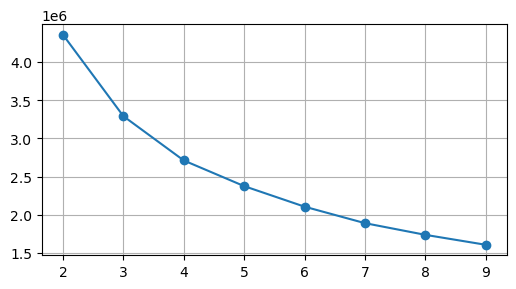

In [71]:
plt.figure(figsize=(6,3))

plt.plot(Ks, intertias, marker='o')
plt.grid()
plt.show()

## Observaciones 

* En este caso, de acuerdo con el metodo del codo, la cantidad optima de clustes es 3 y 4.Se puede ver en la grafica, claramente, que en ese punto la grafico muestra como lo suma 
  de los errores cuadraticos tiene a ser menos prenuciada y por tanto se ve claramente que agregar otro cluster no 
  reduce significativamente la suma de errores.

In [79]:
# Definiendo el modelo con el numero de cluster optimo recomendado por el metodo dlecodgo
kmeans3 = KMeans(n_clusters=3, random_state=1993)

In [80]:
kmeans3.fit(df_pca[['PC_1','PC_2','PC_3']])

KMeans(n_clusters=3, random_state=1993)

In [81]:
df_pca['labels'] = kmeans3.predict(df_pca[['PC_1','PC_2','PC_3']])

In [82]:
#Obtenemos los centroides de los clusters asignados por k-Means
centroids3 = kmeans3.cluster_centers_
centroids3

array([[-0.74333539, -1.65337646, -0.4413054 ],
       [ 1.75011218,  0.15944956,  0.10818033],
       [-0.864197  ,  0.99332837,  0.2138832 ]])

Se proporciona el código para realizar una visualización en 3D.

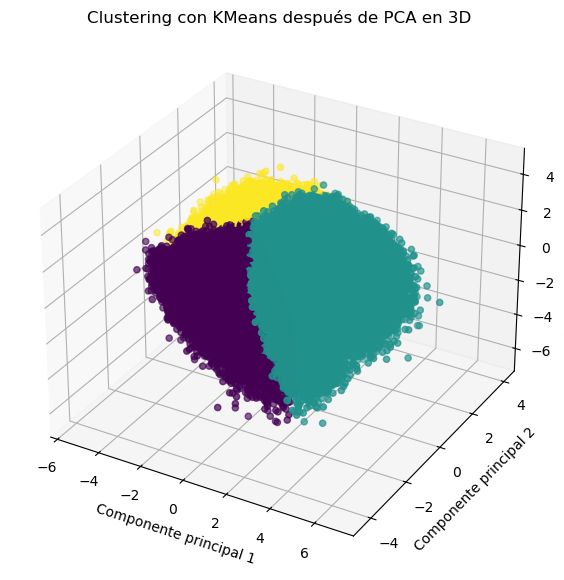

In [83]:
# Visualizar los clusters en 3D
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(df_pca['PC_1'], df_pca['PC_2'], df_pca['PC_3'], c=df_pca['labels'], cmap='viridis')
plt.scatter(centroids3, centroids3, marker='^', s=100,color='black')
ax.set_xlabel('Componente principal 1')
ax.set_ylabel('Componente principal 2')
ax.set_zlabel('Componente principal 3')
ax.set_title('Clustering con KMeans después de PCA en 3D')

plt.show()

In [85]:
#silhouette_avg = silhouette_score(df_pca[['PC_1','PC_2','PC_3']], kmeans3.labels_ )
#silhouette_avg

In [86]:
# Definiendo el modelo con el numero de cluster optimo recomendado por el metodo dlecodgo
kmeans4 = KMeans(n_clusters=4, random_state=1993)

In [87]:
kmeans4.fit(df_pca[['PC_1','PC_2','PC_3']])

KMeans(n_clusters=4, random_state=1993)

In [88]:
df_pca['labels4'] = kmeans4.predict(df_pca[['PC_1','PC_2','PC_3']])

In [89]:
#Obtenemos los centroides de los clusters asignados por k-Means
centroids4 = kmeans4.cluster_centers_
centroids4

array([[-0.93851656, -1.66847094, -0.38139236],
       [ 1.12584169,  0.62652853, -1.38292378],
       [-1.03477457,  0.98997269,  0.36540228],
       [ 1.66670534, -0.2574473 ,  1.07623466]])

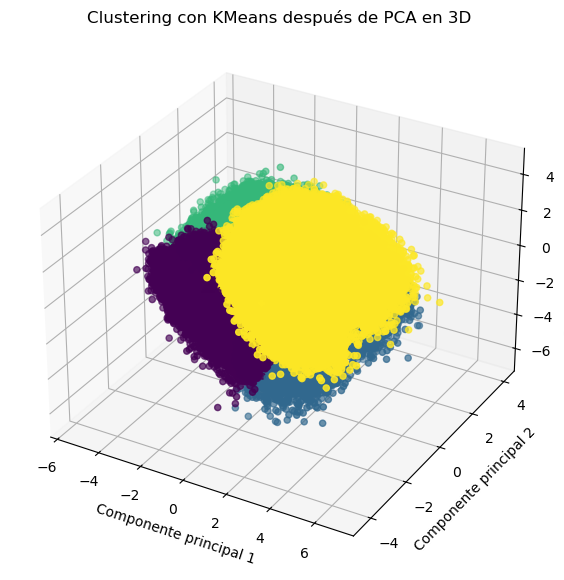

In [90]:
# Visualizar los clusters en 3D
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(df_pca['PC_1'], df_pca['PC_2'], df_pca['PC_3'], c=df_pca['labels4'], cmap='viridis')
plt.scatter(centroids4, centroids4, marker='^', s=100,color='black')
ax.set_xlabel('Componente principal 1')
ax.set_ylabel('Componente principal 2')
ax.set_zlabel('Componente principal 3')
ax.set_title('Clustering con KMeans después de PCA en 3D')

plt.show()

## Observaciones 

* La elección correcta seria 4 la cantidad optimas de clusters. El segundo gráfico confirma esto, ya que revela una sub-estructura que estaba oculta en el clúster verde azulado del gráfico de 3 clústeres.

* Vemos que el grupo morado y verde en este, amarillos en el de 3 cluseres, su patron se mantienen, tienen un compartamiento mas caracterisiticos y contante. En este ultimo vemos que el mayor que era el verdad el primero, tenia un subgrupo oculta, el cual no se podia ver en el primero, esto podria ser solictudes fraudlentas ocultas en este grupo.

* No se utilizo el metodo de la silueta ya que el proceso dura mucho debido a la cantidad casos en el conjunto de datos, sino hubiera utiliza esta metrica para tener una confrmacion cuantitativa para comparlos.